In [32]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


In [33]:
mnist = fetch_openml('mnist_784', version=1)

In [34]:
mnist

{'data':        pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
 0           0       0       0       0       0       0       0       0       0   
 1           0       0       0       0       0       0       0       0       0   
 2           0       0       0       0       0       0       0       0       0   
 3           0       0       0       0       0       0       0       0       0   
 4           0       0       0       0       0       0       0       0       0   
 ...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
 69995       0       0       0       0       0       0       0       0       0   
 69996       0       0       0       0       0       0       0       0       0   
 69997       0       0       0       0       0       0       0       0       0   
 69998       0       0       0       0       0       0       0       0       0   
 69999       0       0       0       0       0       0       0       0       0   
 
      

In [35]:
X = mnist['data'].to_numpy().astype(np.float32)
y = mnist['target'].to_numpy().astype(int)

In [36]:
X /= 255.0

In [37]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(70000, 784), dtype=float32)

In [38]:
encoder = OneHotEncoder(sparse_output=False)

In [39]:
y = encoder.fit_transform(y.reshape(-1, 1))

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [41]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [42]:
class SimpleNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.w1 = np.random.rand(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.w2 = np.random.rand(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))
        
        
    def forward(self, X):
        self.z1 =  np.dot(X, self.w1) + self.b1
        self.a1 = np.tanh(self.z1)
        self.z2 = np.dot(self.a1, self.w2) +  self.b2
        self.a2 = self.softmax(self.z2)
        return  self.a2
    
    
    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    
    def backward(self, X, y):
        # Backward pass
        m = y.shape[0]
        dz2 = self.a2 - y
        self.dw2 = np.dot(self.a1.T, dz2) / m
        self.db2 = np.sum(dz2, axis=0, keepdims=True) / m
        dz1 = np.dot(dz2, self.w2.T) * (1 - np.tanh(self.z1) ** 2)
        self.dw1 = np.dot(X.T, dz1) / m
        self.db1 = np.sum(dz1, axis=0, keepdims=True) / m
        
    def get_parameters(self):
        return [self.w1, self.b1, self.w2, self.b2]
    
    
    def get_gradients(self):
        return  [self.dw1, self.db1,self.dw2, self.db2]
    
    
    
    
    
    

In [43]:
class Adam:
    def __init__(self, parameters, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.parameters = parameters
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        # Initialize first and second moment estimates for each parameter
        self.m = [np.zeros_like(p) for p in self.parameters]
        self.v = [np.zeros_like(p) for p in self.parameters]
        self.t = 0  # Time step
        
    def step(self, grads):
        self.t += 1
        for i, (param, grad) in enumerate(zip(self.parameters, grads)):
            # Update biased first moment estimate
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            # Update biased second moment estimate
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)

            # Compute bias-corrected estimates
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)

            # Update parameter
            param -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
            
            
            


In [46]:
# Simplified SGD optimizer

class SGD:
    def __init__(self, parameters, lr=0.01):
        self.parameters = parameters
        self.lr = lr
    
    def step(self, grads):
        for param,grad in zip(self.parameters, grads):
            param -= self.lr * grad

In [47]:
# Training function
def train(model, optimizer, X_train, y_train, X_test, y_test, epochs, batch_size=64):
    history = {'train_loss': [], 'test_loss': [], 'test_accuracy': []}
    num_batches = X_train.shape[0] // batch_size

    for epoch in range(epochs):
        # Shuffle training data
        permutation = np.random.permutation(X_train.shape[0])
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]

        epoch_loss = 0

        for i in range(num_batches):
            # Get batch data
            start = i * batch_size
            end = start + batch_size
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]

            # Forward pass
            output = model.forward(X_batch)
            loss = np.mean(-np.sum(y_batch * np.log(output + 1e-8), axis=1))  # Cross-entropy loss
            epoch_loss += loss

            # Backward pass
            model.backward(X_batch, y_batch)

            # Get gradients
            grads = model.get_gradients()

            # Update weights
            optimizer.step(grads)

        # Average loss per epoch
        avg_epoch_loss = epoch_loss / num_batches
        history['train_loss'].append(avg_epoch_loss)

        # Evaluate on test set
        test_output = model.forward(X_test)
        test_loss = np.mean(-np.sum(y_test * np.log(test_output + 1e-8), axis=1))
        test_preds = np.argmax(test_output, axis=1)
        test_labels = np.argmax(y_test, axis=1)
        test_accuracy = np.mean(test_preds == test_labels)

        history['test_loss'].append(test_loss)
        history['test_accuracy'].append(test_accuracy)

        if epoch % 5 == 0:
            print(f'Epoch {epoch}: Train Loss: {avg_epoch_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    return history

# Model parameters
input_size = 784  # 28x28 pixels
hidden_size = 128
output_size = 10
epochs = 30
batch_size = 64

# Training with Adam optimizer
print("Training with Adam optimizer...")
model_adam = SimpleNN(input_size, hidden_size, output_size)
parameters_adam = model_adam.get_parameters()
adam_optimizer = Adam(parameters_adam, lr=0.001)
adam_history = train(model_adam, adam_optimizer, X_train, y_train, X_test, y_test, epochs, batch_size)

# Training with SGD optimizer
print("\nTraining with SGD optimizer...")
model_sgd = SimpleNN(input_size, hidden_size, output_size)
parameters_sgd = model_sgd.get_parameters()
sgd_optimizer = SGD(parameters_sgd, lr=0.1)
sgd_history = train(model_sgd, sgd_optimizer, X_train, y_train, X_test, y_test, epochs, batch_size)

# Plotting the results


Training with Adam optimizer...


Epoch 0: Train Loss: 0.3921, Test Loss: 0.2026, Test Accuracy: 0.9421
Epoch 5: Train Loss: 0.0540, Test Loss: 0.0899, Test Accuracy: 0.9719
Epoch 10: Train Loss: 0.0171, Test Loss: 0.0820, Test Accuracy: 0.9760
Epoch 15: Train Loss: 0.0052, Test Loss: 0.0854, Test Accuracy: 0.9770
Epoch 20: Train Loss: 0.0033, Test Loss: 0.1054, Test Accuracy: 0.9741
Epoch 25: Train Loss: 0.0035, Test Loss: 0.1000, Test Accuracy: 0.9765

Training with SGD optimizer...
Epoch 0: Train Loss: 0.6537, Test Loss: 0.3065, Test Accuracy: 0.9125
Epoch 5: Train Loss: 0.1300, Test Loss: 0.1441, Test Accuracy: 0.9604
Epoch 10: Train Loss: 0.0762, Test Loss: 0.1086, Test Accuracy: 0.9685
Epoch 15: Train Loss: 0.0510, Test Loss: 0.0940, Test Accuracy: 0.9719
Epoch 20: Train Loss: 0.0363, Test Loss: 0.0853, Test Accuracy: 0.9744
Epoch 25: Train Loss: 0.0266, Test Loss: 0.0811, Test Accuracy: 0.9749


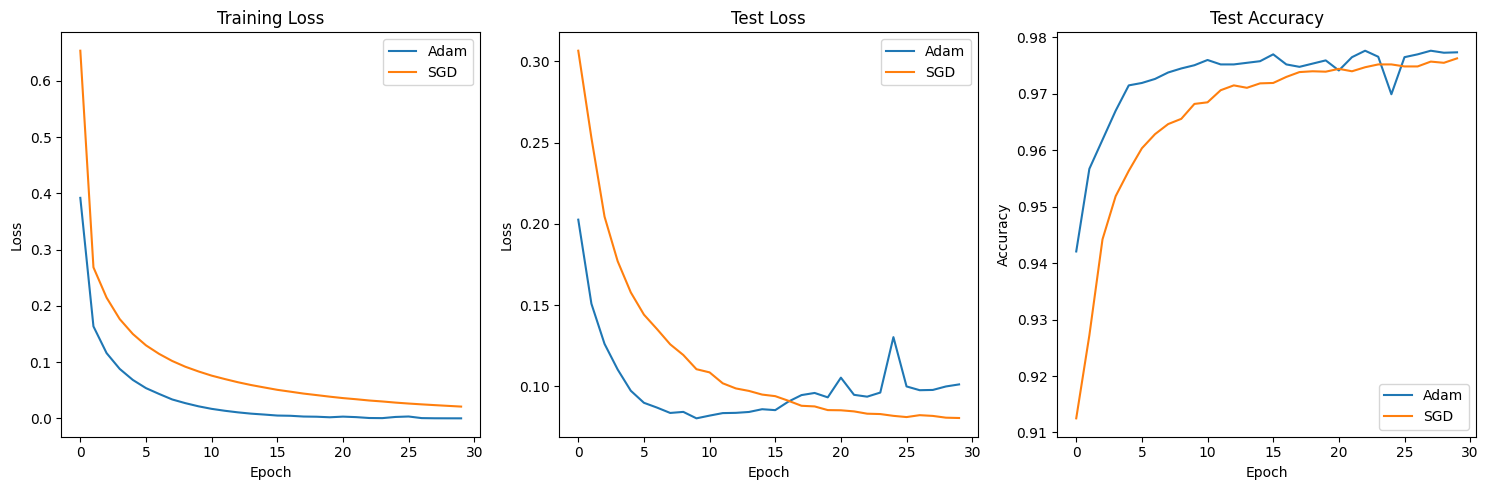

In [48]:

import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(adam_history['train_loss'], label='Adam')
plt.plot(sgd_history['train_loss'], label='SGD')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot test loss
plt.subplot(1, 3, 2)
plt.plot(adam_history['test_loss'], label='Adam')
plt.plot(sgd_history['test_loss'], label='SGD')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot test accuracy
plt.subplot(1, 3, 3)
plt.plot(adam_history['test_accuracy'], label='Adam')
plt.plot(sgd_history['test_accuracy'], label='SGD')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
